# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

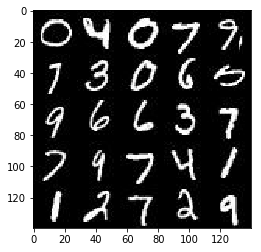

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

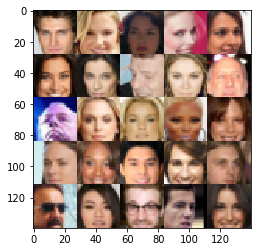

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')


    return inputs_real, inputs_z,learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/bhorkar/miniconda2/envs/dog-project/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        # x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        #use relationship #11 
        #covert to output 7x7
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        #logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    class GAN:
        def __init__(self, real_size, z_size, learning_rate, beta1=0.5):
           # print (real_size)

            self.input_real, self.input_z, self.lr = model_inputs(real_size[0],real_size[1], real_size[2],z_size)

            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                                  real_size[2])

            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
            
    net = GAN(data_shape[1:], z_dim, learning_rate, beta1=beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    show_every = 100;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                    steps += 1
                   # print (batch_images.shape)
                #make the range of images from -1 to 1 
                    batch_images = batch_images * 2
                   # print (batch_images.shape)

                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    # Run optimizers
                    _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                    _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                    
                     
                    if steps % 100 == 0:
                            train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                            train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                            print("Epoch {}/{}...".format(epoch_i+1, epochs),
                                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                                  "Generator Loss: {:.4f}".format(train_loss_g))
                            # Save losses to view after training
                            losses.append((train_loss_d, train_loss_g))
                 

                    if steps % 200 == 0:
                        show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)

    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.6957


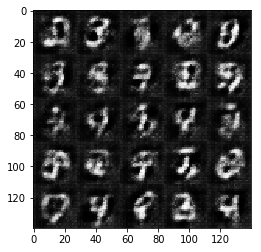

Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.6269... Generator Loss: 0.3420


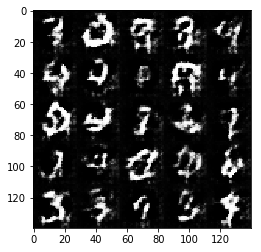

Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.4362
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.7318


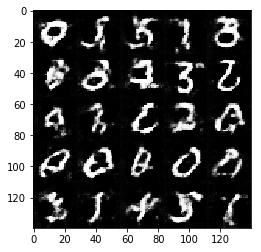

Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.1339


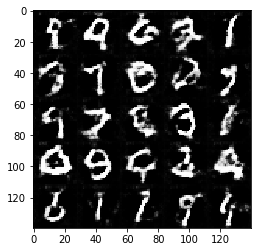

Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.6432


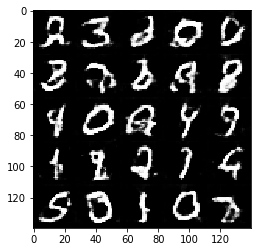

Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.6136


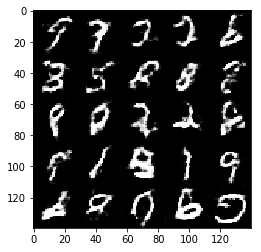

Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 0.9733


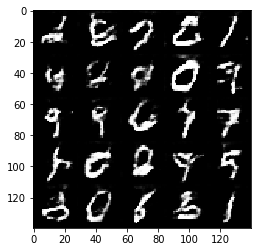

Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.5782


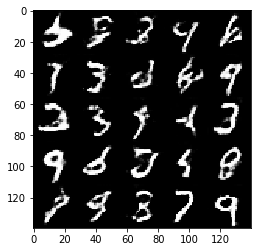

Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 0.6521... Generator Loss: 2.2537


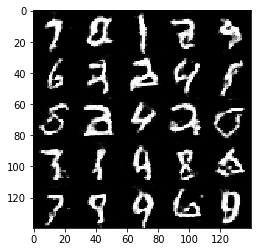

Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.9040
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.3692


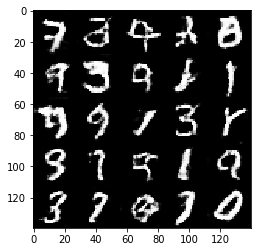

Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 0.6419... Generator Loss: 1.6918


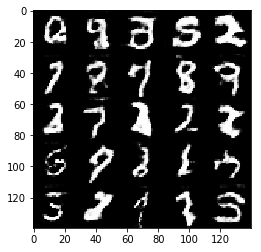

Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 0.8899


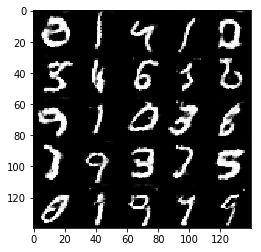

Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.2398


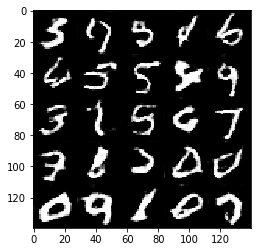

Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 1.0474


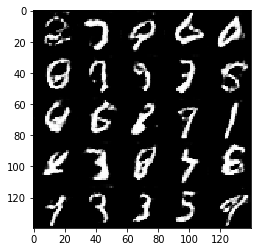

Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.2924


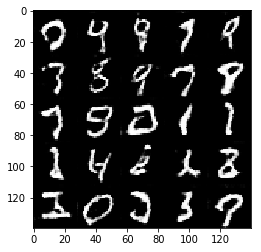

Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 0.5606... Generator Loss: 1.8003


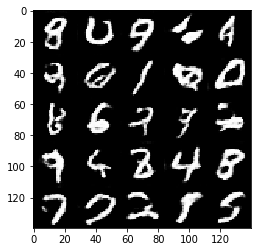

Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.8840


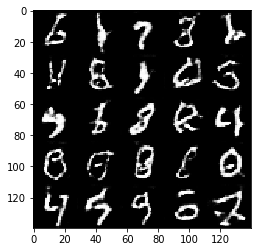

Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 1.5608


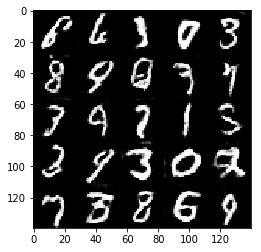

Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 2.0136
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 2.8000


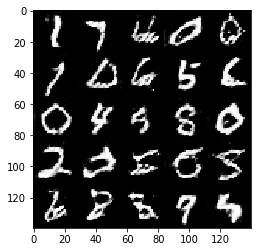

Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.2489
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.3048


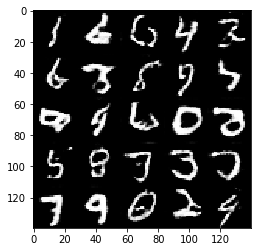

Epoch 2/2... Discriminator Loss: 1.7802... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 2.0988


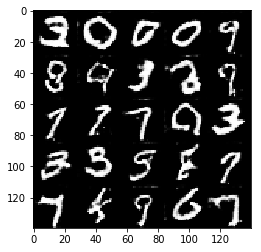

Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.4806
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.7032


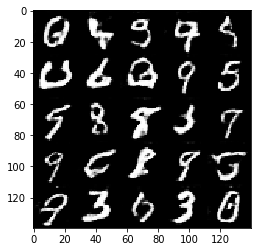

Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.7508


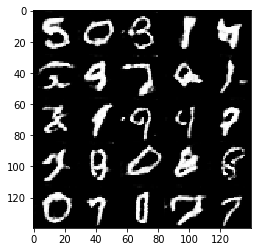

Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 2.0312
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.3435


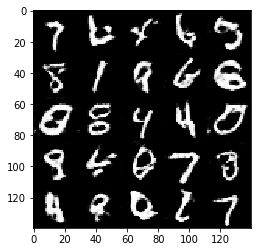

Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 4.8837
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.4042


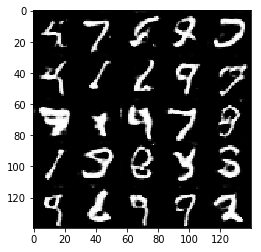

Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.8137


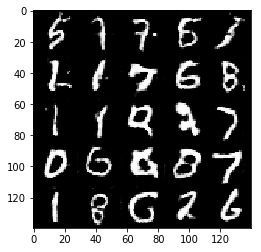

Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.4667


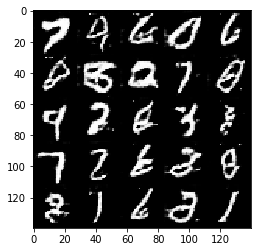

Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.5012


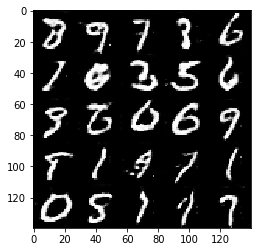

Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.3910
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.8181


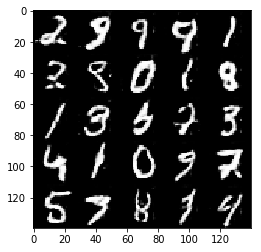

Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.5471
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.4925


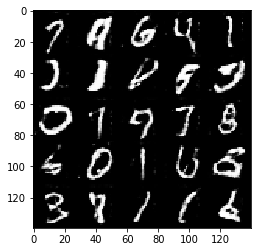

Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 2.3436
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.2485


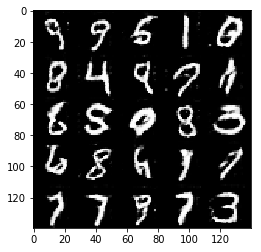

Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 2.1621
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.4784


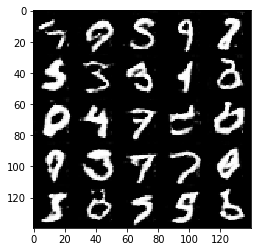

Epoch 2/2... Discriminator Loss: 0.4626... Generator Loss: 2.5424
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 1.8217


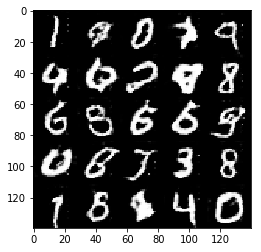

Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.7227
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.5920


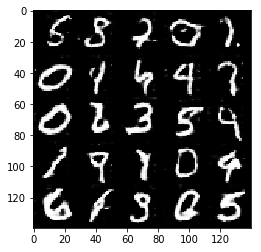

Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.4558


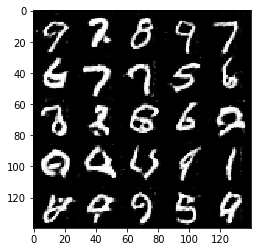

Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.9177


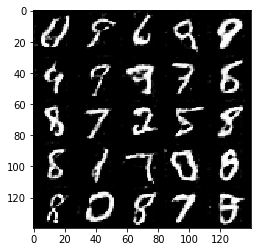

Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.4928


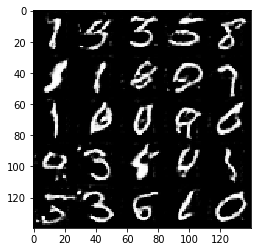

Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.6339


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.9918... Generator Loss: 0.2750


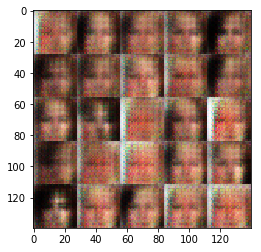

Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.4689


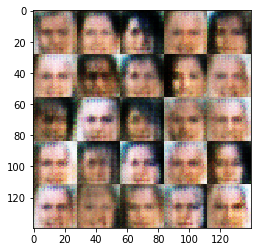

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5549


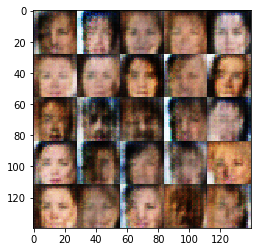

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7287


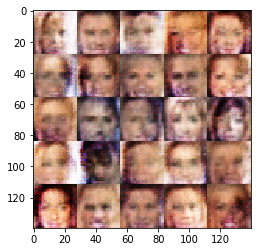

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7759


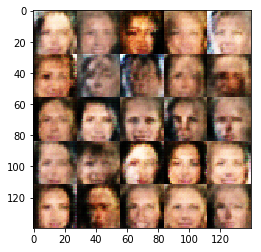

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8538


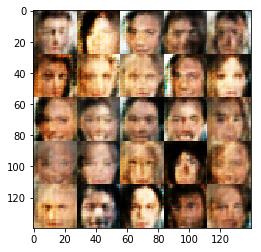

Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.8304


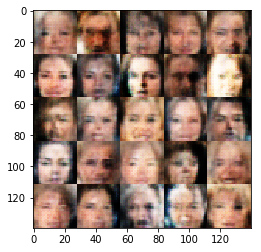

Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6660


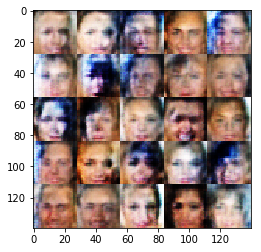

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.4803


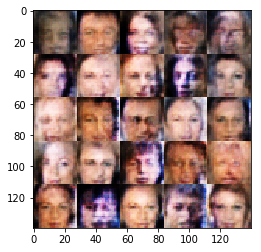

Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 2.0002
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.5952


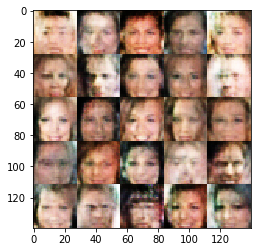

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 1.1773


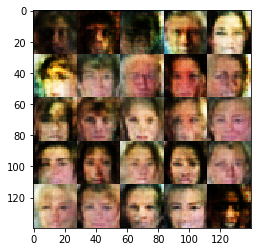

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.2803


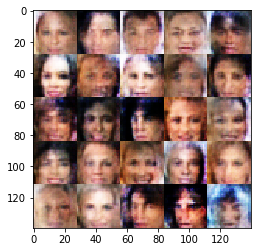

Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6395


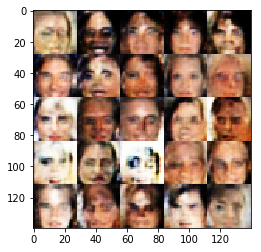

Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 1.9589


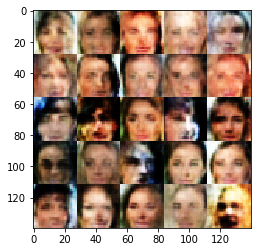

Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 4.4749


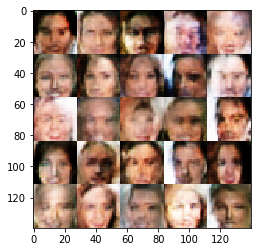

Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.3937


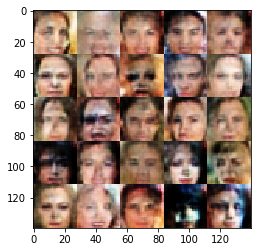

Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.1032


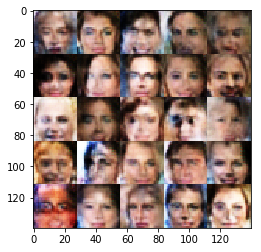

Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 4.5817


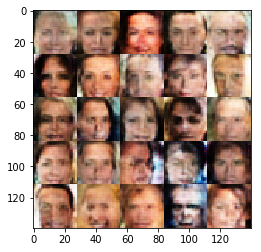

Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 1.9941
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.4403


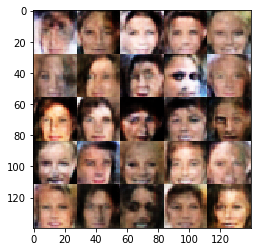

Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.6604
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 5.0247


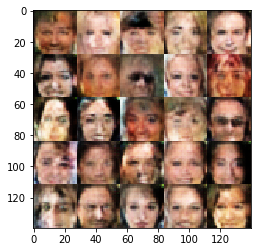

Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 3.4927
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 2.6521


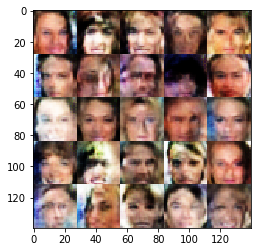

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.7147


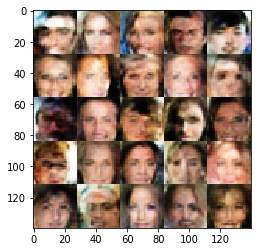

Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 3.8301


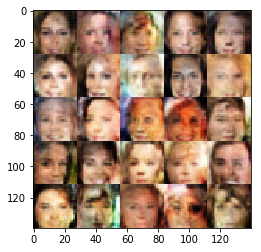

Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 5.9287
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.7670


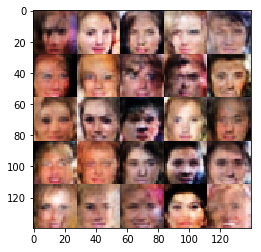

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.1999


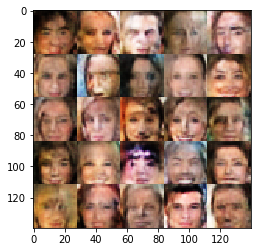

Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.5227


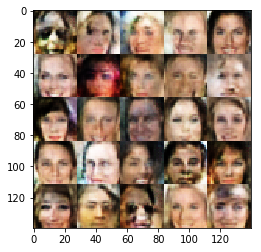

In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6805


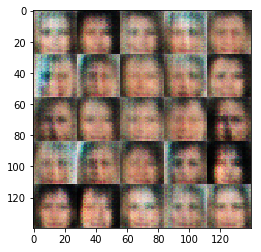

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.4479


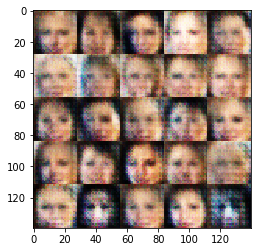

Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.4401


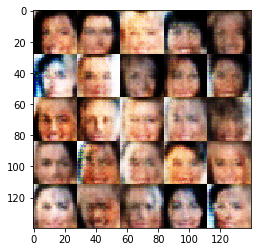

Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.3515


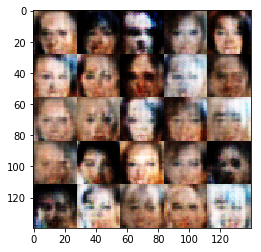

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.4970


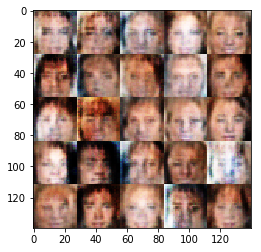

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7554


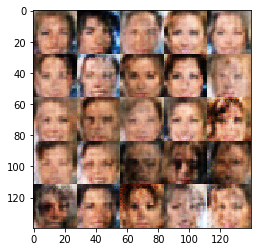

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7008


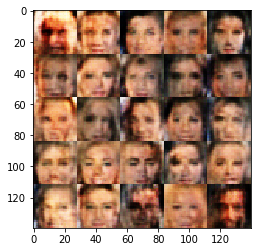

Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.5034


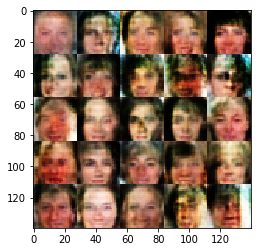

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8275


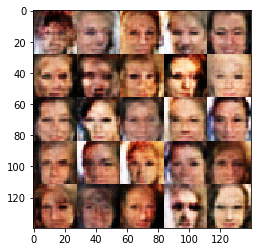

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7223


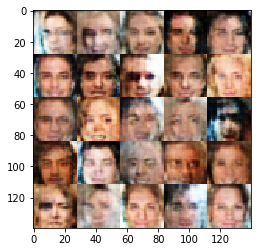

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6952


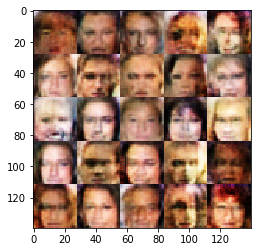

Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.5777


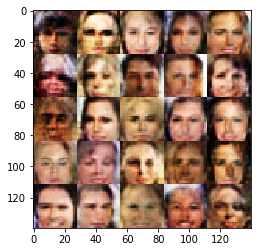

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7596


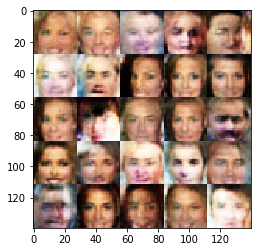

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8322


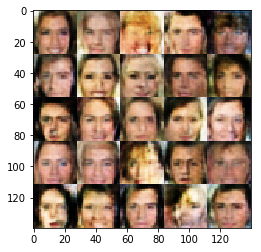

Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.9087


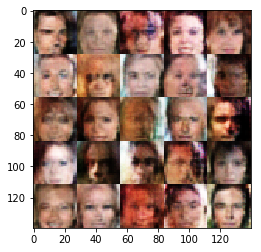

Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9642


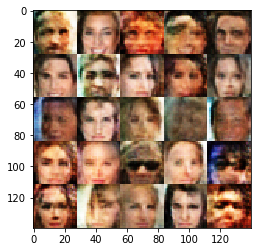

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6641


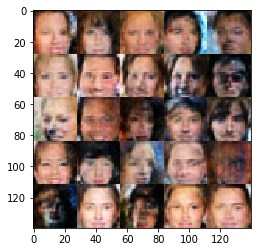

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7274


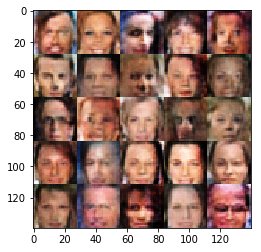

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7547


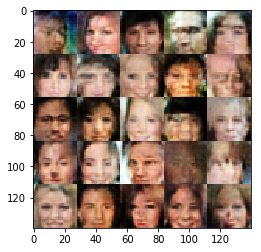

Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7635


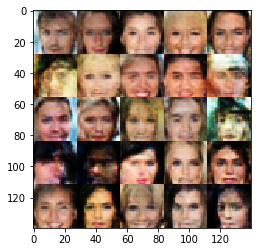

Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8398


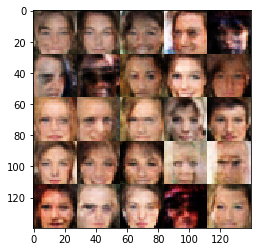

Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.2272


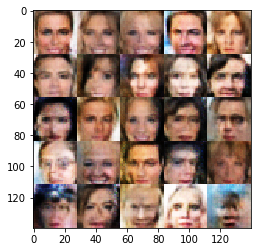

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5978


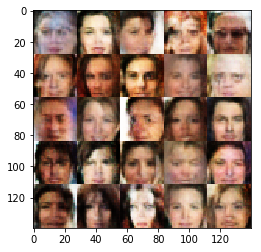

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 0.3259


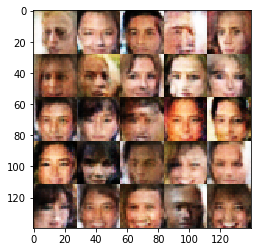

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.